# Classifier v.3

In [181]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pandas import read_csv, DataFrame, Series
import pandas as pd
from sklearn.model_selection import train_test_split
from helper import *
from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [ ]:
# create .csv from .matrix

# with open("19NQ013_samples.matrix") as textFile:
#     data = np.array([sample.split() for sample in textFile])
#
# with open('19NQ013_samples.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data)

In [29]:
samples = read_csv('19NQ013_samples.csv')

#### Prepare data

In [30]:
# leave only OT_ and CR_ patients
drop_list = []
for patient in samples.columns:
    if patient[:2] != 'OT' and patient[:2] != 'CR':
        drop_list.append(patient)
genes = samples['genes'].to_list()
samples = samples.drop(drop_list[1:],axis=1)

In [31]:
# recode patient status to numeric (OT = 0, CR = 1)
patients = samples.columns[1:]
patients_labels = pd.DataFrame({'status':  [p[:2] for p in patients]})
print('Patients amount: \n', patients_labels.value_counts())

patients_labels = patients_labels.replace({'OT':0, 'CR':1})
labels = ['OT', 'CR']

Patients amount: 
 status
OT        15
CR        12
dtype: int64


#### Filter data

In [32]:
from scipy import stats
print('Number of all genes: ', samples.sum(axis=1).count())

Number of all genes:  187626


In [49]:
print('Number of genes which have > 10 counts: ', (samples.sum(axis=1) > 20).value_counts())
print('Number of genes which have a least 4 counts in one of vzorku: ', (samples.max(axis=1) > 4).value_counts())

Number of genes which have > 10 counts:  False    104301
True      83325
dtype: int64
Number of genes which have a least 4 counts in one of vzorku:  False    119072
True      68554
dtype: int64


In [52]:
# remove genes with < 20 read counts in all samples and genes which have > 5 read counts in at least one sample
samples = samples[(samples.sum(axis=1) > 20) & (samples.max(axis=1) > 5)]

In [ ]:
# remove genes with zero counts in all samples
# print('Number of zero gene expression: ', (samples.sum(axis=1) <= 1).sum())
# samples = samples[samples.sum(axis=1) > 1]

# remove genes with a low mean normalized counts
# mean = samples.mean(axis=1)
# print('Number of genes with low mean counts: ', mean[mean < 2].count())
# samples = samples[mean > 2]

# print('Number of all genes after removing: ', samples.sum(axis=1).count())
# samples.head()

# remove genes with an extreme count outlier
# zsc = np.abs(stats.zscore(samples[samples.columns[1:]]))
# print(zsc[zsc>100])
# print(samples[(zsc > 3).all(axis=1)])
# samples = samples[(np.abs(stats.zscore(samples)) < 3).all(axis=1)]

In [53]:
print('Number of all genes after data filtering: ', samples.sum(axis=1).count())

Number of all genes after data filtering:  58526


#### Prepare dataset for classification


In [54]:
# transpose
samples = samples.transpose()
samples.columns = samples.iloc[0]
samples = samples.drop(["genes"]).apply(pd.to_numeric)
samples = samples.reset_index(drop=True)
samples.head()

genes,ENST00000390396.1,ENST00000390400.2,ENST00000390369.2,ENST00000390468.1,ENST00000390424.2,ENST00000390463.3,ENST00000390440.2,ENST00000390436.2,ENST00000390435.1,ENST00000631690.1,...,ENST00000499853.2,ENST00000383620.4,ENST00000563214.1,ENST00000626385.1,ENST00000617319.1,ENST00000646111.1,ENST00000647527.1,ENST00000634119.1,ENST00000631343.1,ENST00000635730.1
0,0,6,3,4,0,0,2,4,3,2,...,5,13,0,2,1,2,1,3,0,0
1,1,12,0,7,5,3,5,5,12,3,...,5,9,2,5,2,5,4,1,2,3
2,1,4,0,4,3,2,4,12,12,0,...,6,7,3,7,3,3,1,0,0,0
3,1,2,0,4,0,1,1,4,0,0,...,4,0,2,2,1,5,4,4,0,1
4,0,8,0,5,8,2,5,6,14,2,...,6,22,1,4,1,7,7,1,1,0


#### Initialize train and test data

In [ ]:
# split samples into train and test subsets (randomly!)
# X_train, X_test, y_train, y_test = train_test_split(samples, patients_labels, test_size=0.5)
# print('Train subset: (0 = OT, 1 = CR)\nid', y_train)
# print('Test subset: (0 = OT, 1 = CR)\nid', y_test)

#### 5x20 cross validation for future selection

In [57]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
np.random.seed(42)
X = samples
y = patients_labels

X.head()

genes,ENST00000390396.1,ENST00000390400.2,ENST00000390369.2,ENST00000390468.1,ENST00000390424.2,ENST00000390463.3,ENST00000390440.2,ENST00000390436.2,ENST00000390435.1,ENST00000631690.1,...,ENST00000499853.2,ENST00000383620.4,ENST00000563214.1,ENST00000626385.1,ENST00000617319.1,ENST00000646111.1,ENST00000647527.1,ENST00000634119.1,ENST00000631343.1,ENST00000635730.1
0,0,6,3,4,0,0,2,4,3,2,...,5,13,0,2,1,2,1,3,0,0
1,1,12,0,7,5,3,5,5,12,3,...,5,9,2,5,2,5,4,1,2,3
2,1,4,0,4,3,2,4,12,12,0,...,6,7,3,7,3,3,1,0,0,0
3,1,2,0,4,0,1,1,4,0,0,...,4,0,2,2,1,5,4,4,0,1
4,0,8,0,5,8,2,5,6,14,2,...,6,22,1,4,1,7,7,1,1,0


In [182]:
n_splits = 5
genes_range = [3, 5, 10, 30, 100] # number of selected genes
results = dict((k, []) for k in genes_range)

# cross validation
# cv = StratifiedKFold(n_splits=n_splits).split(X, y)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            if auc < 0.4:
                print('auc = ', auc)
                print(y_test)
                print(probabilities)
                print('---')
            auc_scores.append(auc)

        results[selected_k].append(auc_scores)

auc =  0.25
    status
10       0
1        0
21       1
23       1
[0.18521733 0.69665798 0.08419465 0.24586499]
---
auc =  0.25
    status
10       0
1        0
21       1
23       1
[0.55615954 0.59139707 0.56816583 0.5482225 ]
---
auc =  0.25
    status
10       0
1        0
21       1
23       1
[0.82904009 0.99052636 0.85070637 0.07360743]
---
auc =  0.25
    status
14       0
18       1
13       0
26       1
[0.46943794 0.40979356 0.14545152 0.14133726]
---
auc =  0.25
    status
14       0
18       1
13       0
26       1
[0.34017361 0.13105066 0.96256907 0.508451  ]
---
auc =  0.25
    status
14       0
18       1
13       0
26       1
[0.17168473 0.00693768 0.88822744 0.31664315]
---
auc =  0.25
    status
14       0
18       1
13       0
26       1
[0.01194319 0.00561063 0.94850604 0.11063449]
---
auc =  0.25
    status
6        0
17       1
15       1
0        0
[0.14518004 0.43748504 0.04494333 0.45346154]
---
auc =  0.0
    status
6        0
17       1
15       1
0        

/Users/karinabalagazova/miniconda3/envs/RPZ/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### Show cross-validation results

[[[0.25, 0.25, 0.25, 1.0, 0.8333333333333334, 0.0, 0.0, 1.0, 0.5, 0.8333333333333334, 1.0, 0.75, 1.0, 0.5, 1.0, 1.0, 1.0, 0.25, 0.75, 0.0, 0.625, 0.5, 0.5, 0.5, 0.0, 0.5, 0.625, 1.0, 0.75, 1.0, 0.5, 0.0, 0.375, 0.75, 0.6666666666666667, 1.0, 0.5, 0.75, 0.5, 0.0, 0.0, 0.5, 0.25, 0.25, 0.6666666666666667, 0.5, 0.5, 0.5, 0.25, 0.33333333333333337, 0.5, 0.5, 1.0, 0.5, 1.0, 0.375, 0.5, 1.0, 0.5, 0.33333333333333337, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 1.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.33333333333333337, 0.0, 0.75, 0.75, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.6666666666666667, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0.25, 0.0, 0.75, 0.0, 0.25, 0.5, 0.5, 0.5, 1.0], [1.0, 0.5, 0.75, 0.0, 0.6666666666666667, 0.5, 0.25, 0.25, 0.25, 1.0, 0.25, 0.75, 0.75, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.33333333333333337, 0.25, 0.25, 0.75, 0.75, 0.6666666666666667, 0.5, 0.0, 1.0, 0.5, 0.0, 1.0, 1.0, 0.5, 0.75, 0.6666666666666667, 0.5, 0.75, 0.5, 0.5, 0.0, 1.0, 0.25, 0.5, 0.5, 0.0, 0.75, 0.5, 0.5, 0.5, 0.33333333333333337, 1.0

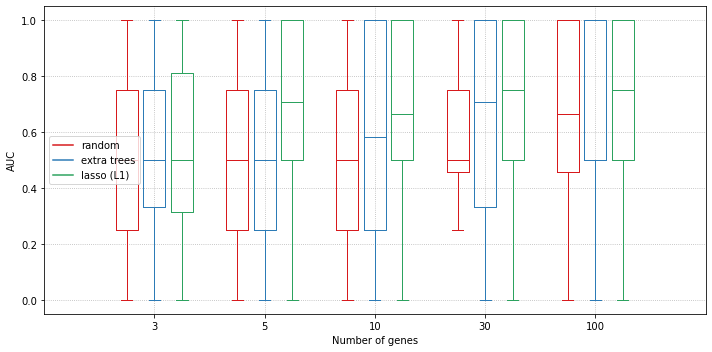

In [183]:
# modify data for boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups = group_data(results)
print(data_groups)

# show boxplots
show_cv(data_groups, genes_range, methods_names)

#### Add information about immunosuppressive drugs

In [79]:
# Load data
samples_IS = read_csv('Kodovani_skupin_proDEG_vlivIS.csv')

patients_tmp = patients.copy()
patients_tmp = patients_tmp.to_frame(index=False).replace(to_replace=r'^OT_', value='T', regex=True)
patients_tmp.columns = ['RNA_seq_label']
samples_IS = pd.merge(patients_tmp, samples_IS, on='RNA_seq_label')

samples_IS.head()

,RNA_seq_label,Skupina,CNI_nonCNI,IS at sampling,CNI_ano,steroids_ano,"antiproliferative_drugs (AZA, MMF)"
0,T05,OT,0,no,0,0,0
1,T17,OT,0,no,0,0,0
2,T18,OT,0,no,0,0,0
3,T21,OT,0,no,0,0,0
4,T23,OT,0,no,0,0,0


In [86]:
# print(samples_IS.columns[:4])
# print(patients)
samples_IS = samples_IS.drop(samples_IS.columns[:4], axis=1)
samples_IS.columns = ['CNI', 'steroids', 'antiproliferative_drugs']
samples_genes_IS = pd.concat([samples_IS, samples], axis=1).reindex(samples_IS.index)
